# Parameters

In [7]:
# ------- PARAMETERS ------- #           

RUNS = [17]           # run indexes

root = '/pnfs/pic.es/data/cta/LST/LST2/Data/ZFITS/' # path to all folders with the .zfits files

# -------------------------- #

# other parameters

dir_files  = '/data/cta/users-ifae/summer_students/jjimenezq/PEDESTAL_ANALYSIS-LST2/csv_files/'#'csv_files/' # path (relative or absolute) to the .csv files
dir_graphs = 'graphs/'    # path (relative or absolute) to the images created

subrun        = 0         # number of subrun to analyse (0 will be ok)
graphs_format = 'pdf'     # file format of images
random_pixels = 5         # number of random pixels we extract for the pedestal plots

Some packages needed

In [8]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import auxiliar          as aux
aux.parameters()

from scipy.fft             import fft, fftfreq, fftshift
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates   import EngineeringCameraFrame
from traitlets.config      import Config
from ctapipe.io            import EventSource

# extracting the number of LST
LST_camera = aux.find_LST_num(root) 

# getting geometry of the camera
date, subruns = aux.search(root,RUNS[0])    
config  = Config({'LSTEventSource': {'default_trigger_type': 'ucts','allowed_tels': [1],
                                    'min_flatfield_adc': 3000,'min_flatfield_pixel_fraction': 0.8,},})  

path    = root + date+'/'+'LST-'+LST_camera+'.1.Run'+str(RUNS[0]).zfill(5)+'.'+str(subrun).zfill(4)+'.fits.fz'
source  = EventSource(input_url=path, config=config)
camgeom = source.subarray.tel[1].camera.geometry

# creating the folder if dont exist
aux.create_folder(dir_graphs)  

# For the pedestal analysis

Only taking the mean value of the charges of each event


Analysing RUN 17 subrun 0

Reading CSV...

Calculating means...

Calculating fft...
50%...
100%

The limit in the frequency filtering is 1940.02

Start filtering...
Filtering... 0.0%
Filtering... 10.78%
Filtering... 21.56%
Filtering... 32.35%
Filtering... 43.13%
Filtering... 53.91%
Filtering... 64.69%
Filtering... 75.47%
Filtering... 86.25%
Filtering... 97.04%
Filtering    100%

The smallest multiple frequency is 1.99999

fft of Pixel 692 and the respective points found



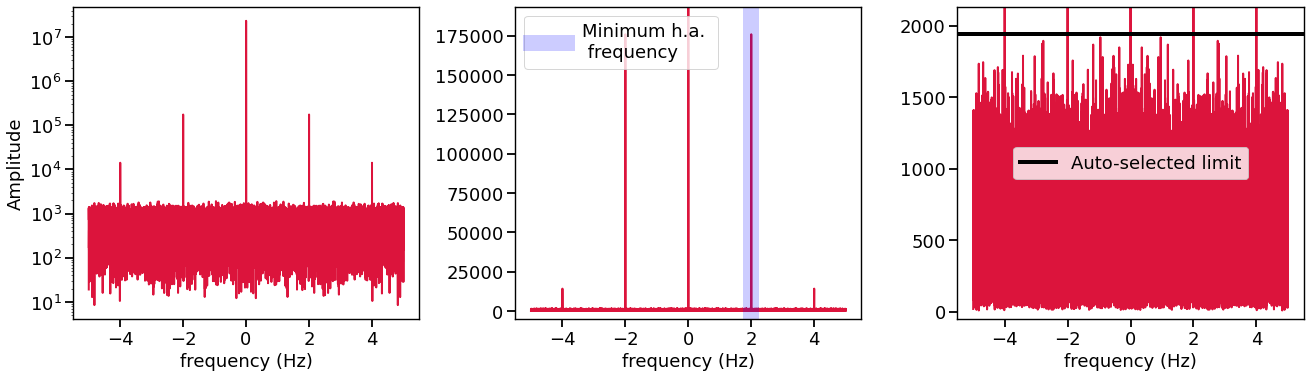


The high amplitudes are multiples of: 2.0 Hz 





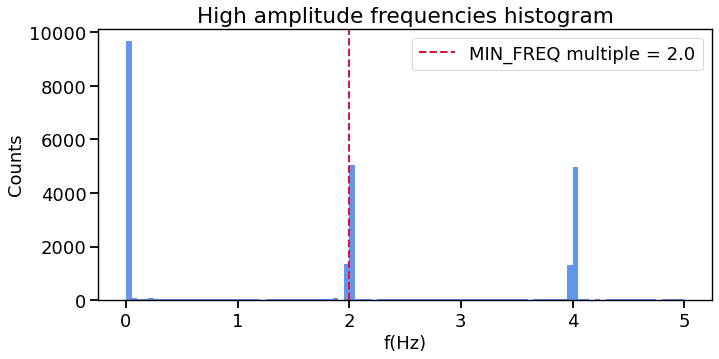

Pixel 1650: 


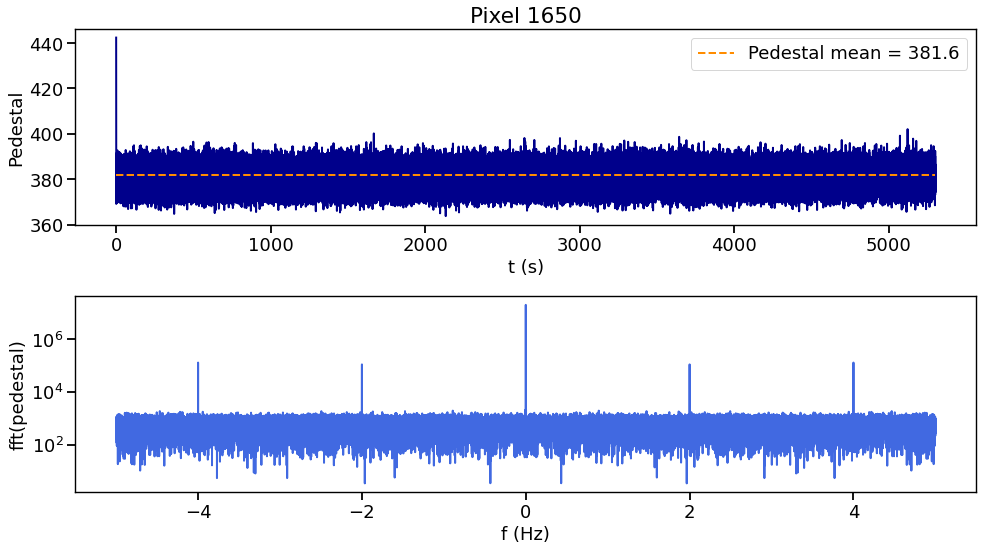

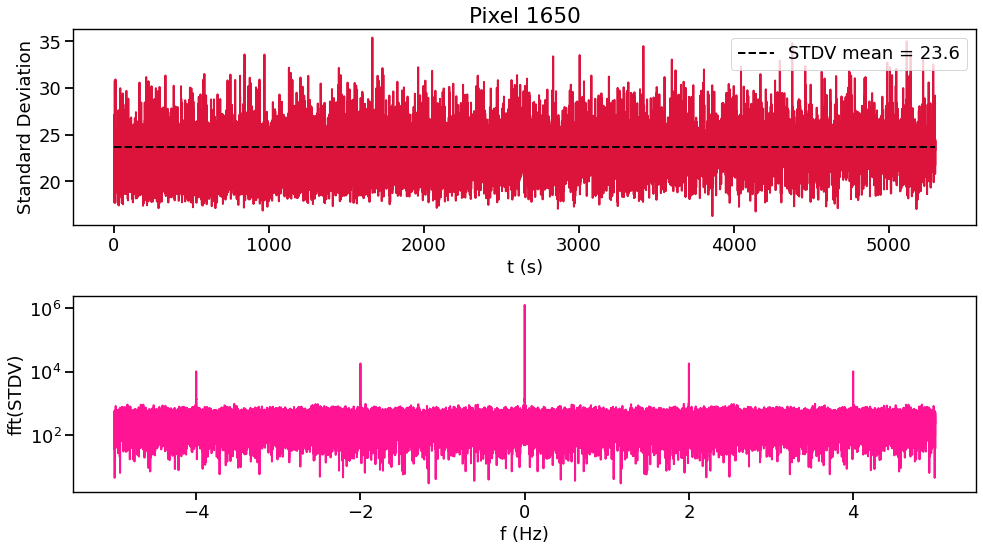

Pixel 1261: 


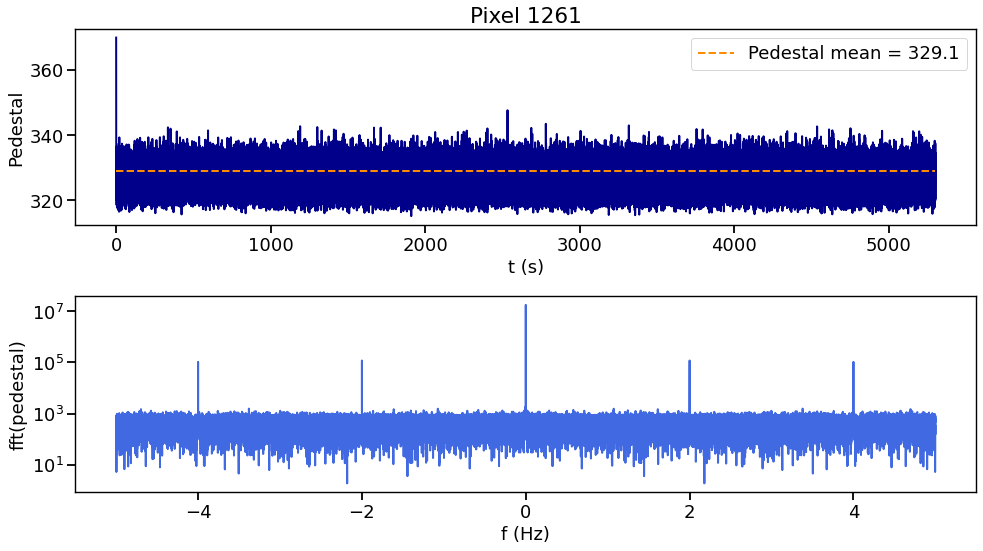

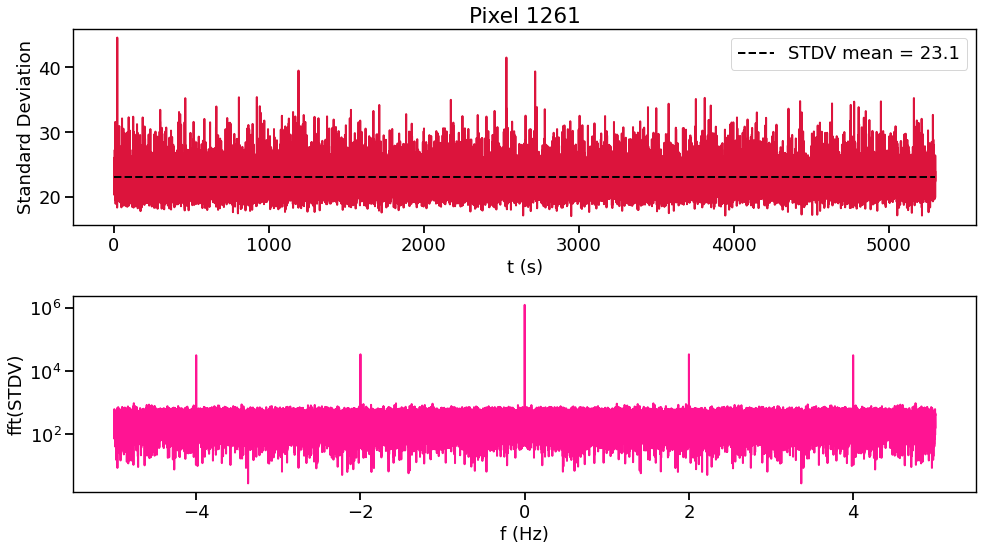

Pixel 1633: 


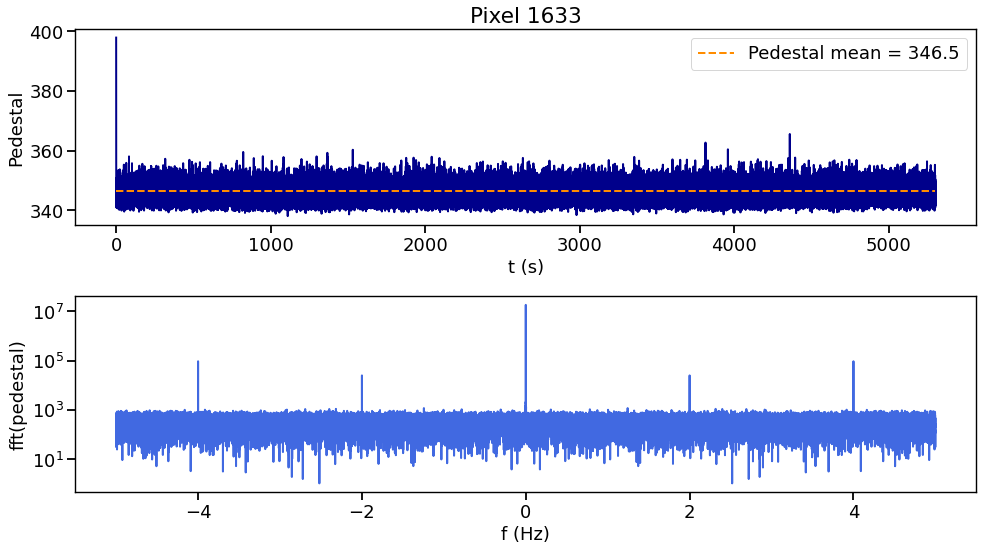

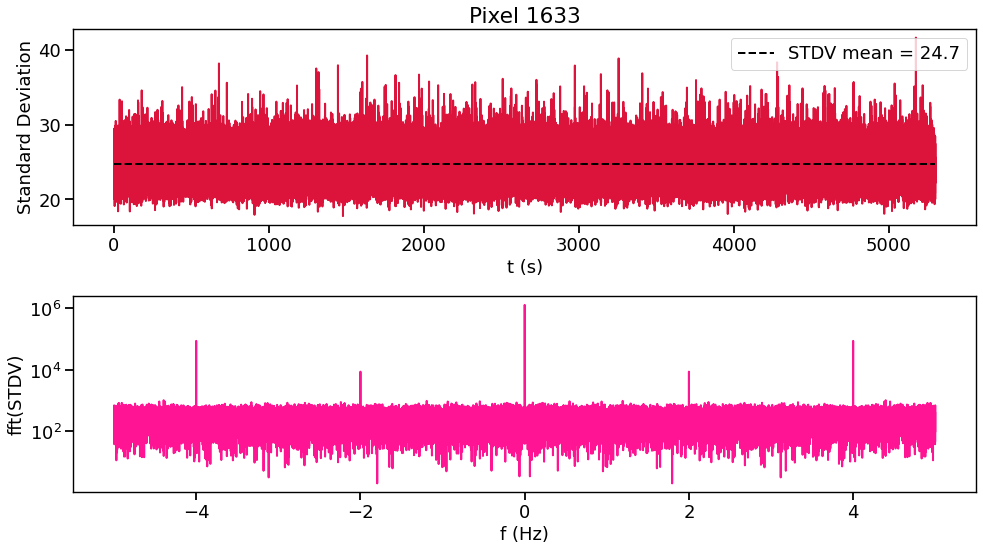

Pixel 1416: 


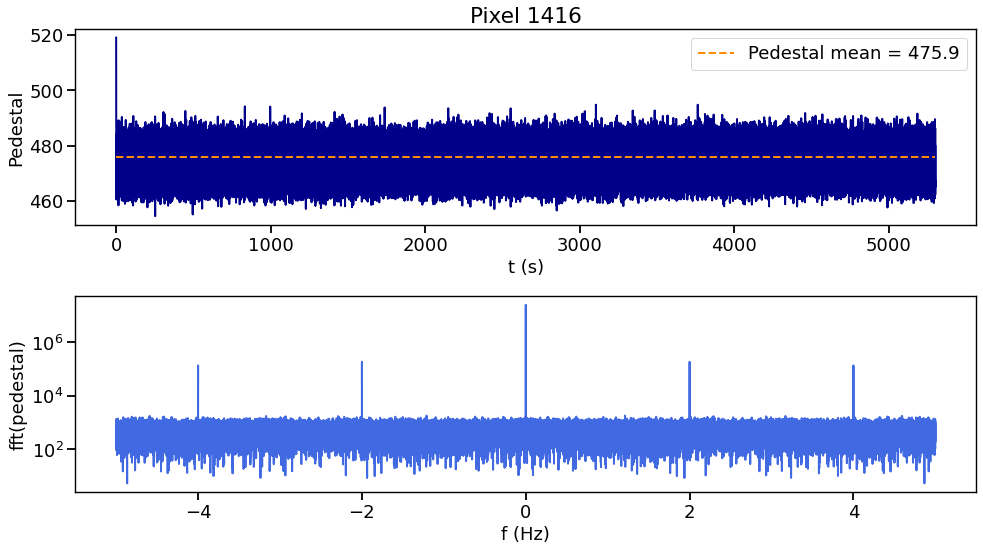

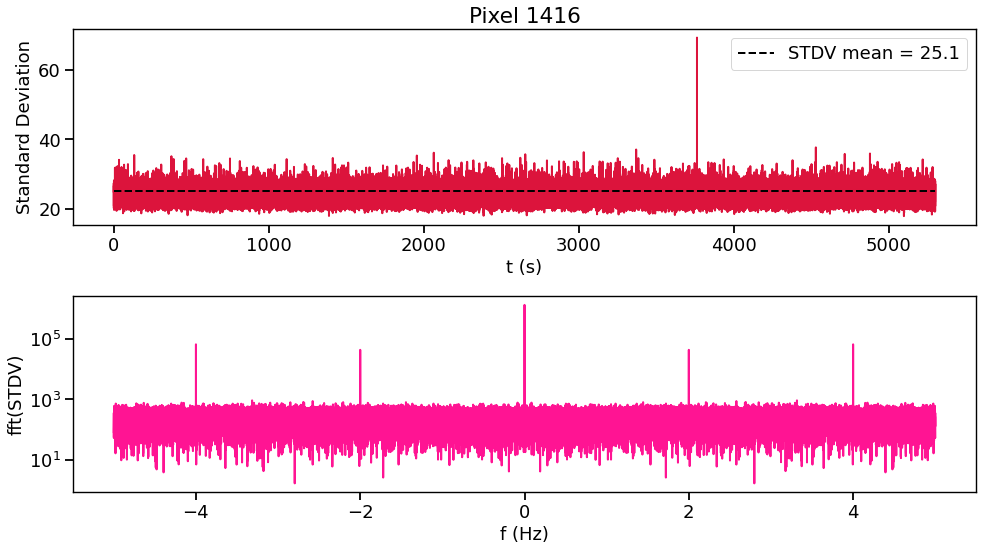

Pixel 1268: 


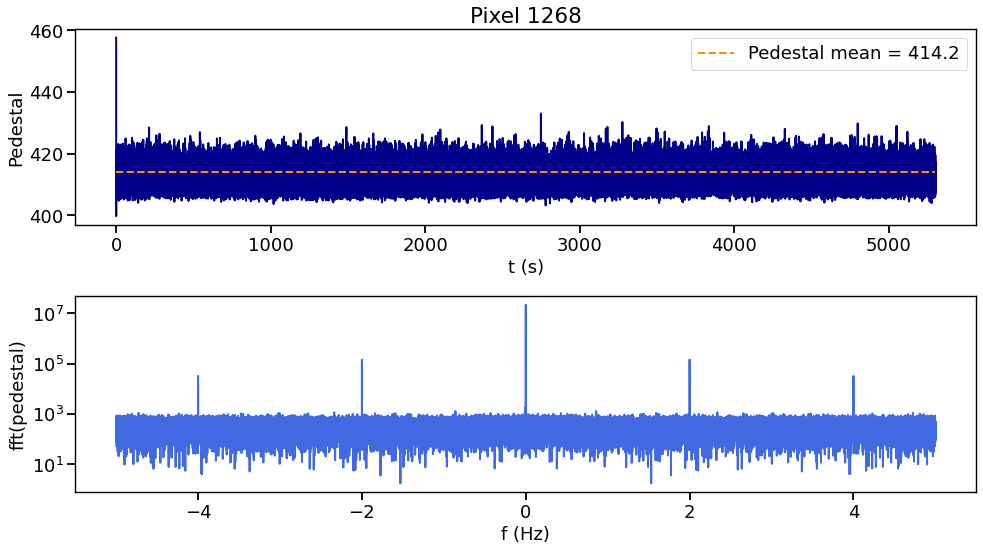

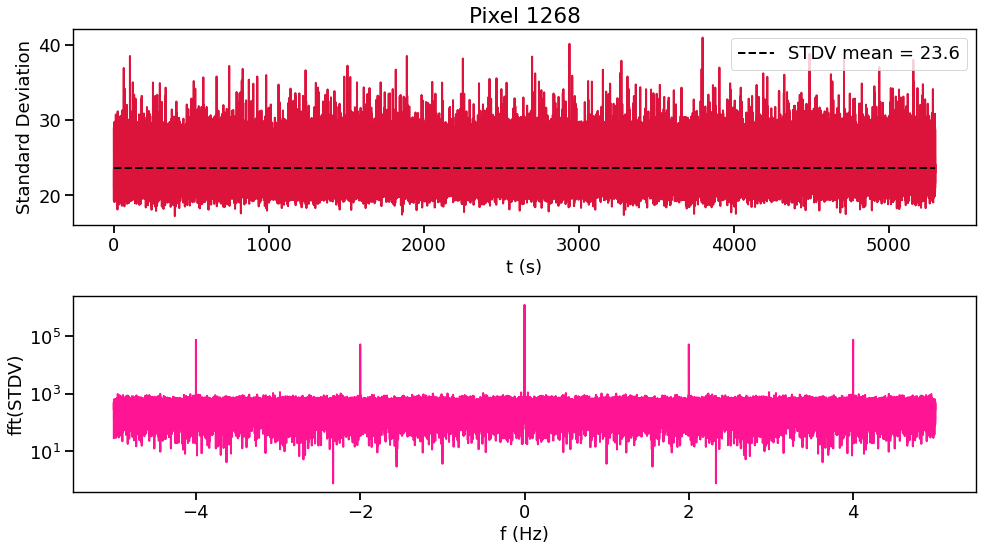

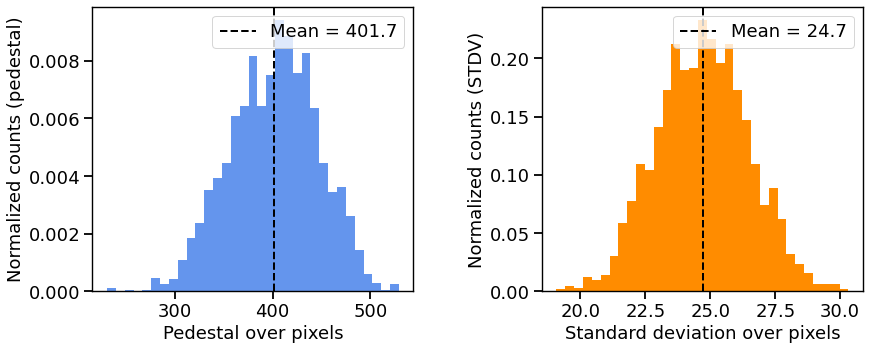

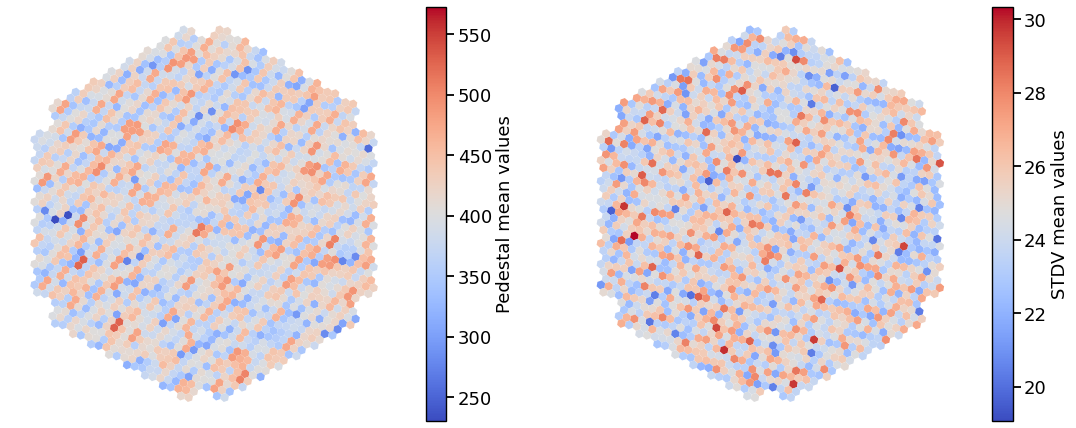


--------------------------------------------------
--------------------------------------------------




In [9]:
for RUN in RUNS: 
    
    print('\nAnalysing RUN '      + str(RUN) + ' subrun ' + str(subrun) + '\n')
    path = dir_files + 'data_Run' + str(RUN) + '_Subrun'  + str(subrun) + '.csv'

    # reading the data from the csv
    pedestal, stdv, time = aux.readPedestal(path)
    
    
    # ------- fourier transform and means ------- #

    dt = np.mean(np.diff(time))    # time-step
    N  = len(time)                 # number of elements 
    f  = fftshift(fftfreq(N, dt))  # frequency range

    #mean values calculus
    print('\nCalculating means...\n')
    meanPedestal = [np.mean(pedestal[i]) for i in range(1855)]
    meanStdv     = [np.mean(stdv[i])     for i in range(1855)]

    #fourier transforms of mean and rmse
    print('Calculating fft...')
    fftPedestal  = [fftshift((fft(np.array(pedestal[i])))) for i in range(1855)]
    print('50%...')
    fftStdv      = [fftshift((fft(np.array(stdv[i]    )))) for i in range(1855)]
    print('100%\n')
    
    # ------------------------------------------- #
    
    
    # filtering the frequencies
    abs_f, f_around = aux.freqFilterPedestal(f, fftPedestal)
    
    
    # ----- histogram frequencies plot ----- #

    fig,ax1 = plt.subplots(figsize=(11,5))
    ax1.set_title('High amplitude frequencies histogram')
    ax1.set_xlabel('f(Hz)')
    ax1.set_ylabel('Counts')
    ax1.hist(abs_f, bins=100, color='cornflowerblue')

    ax1.axvline(np.mean(f_around), linestyle='--', color='crimson',
                label='MIN_FREQ multiple = ' + str(round(np.mean(f_around),3)))
    
    plt.legend()
    plt.savefig(dir_graphs + 'hist_highAmplitudes_Run' + str(RUN) + '_Subrun' + str(subrun) + '.' 
                + graphs_format, bbox_inches='tight', format=graphs_format)
    plt.show()
    
    # -------------------------------------- #    
    
    # pedestal and stdv fft plots
    aux.plot_fftsPedestal(random_pixels, RUN, subrun, time, pedestal, stdv, fftPedestal, fftStdv, 
                          meanPedestal, meanStdv, graphs_format, dir_graphs, f)
  
    
    
    # ----------- histogram means ---------- #
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.tight_layout()

    yhist, xhist, patches = ax1.hist(meanPedestal, bins=33, color='cornflowerblue', density=True, 
                                     histtype='stepfilled')
    ax1.axvline(np.mean(meanPedestal), linestyle='--', color='k', label='Mean = ' 
                + str(round(np.mean(meanPedestal),1)))

    ax1.legend()
    ax1.set_ylabel('Normalized counts (pedestal)')
    ax1.set_xlabel('Pedestal over pixels')

    yhist, xhist, patches = ax2.hist(meanStdv, bins=33, color='darkorange', density=True, histtype='stepfilled')
    ax2.axvline(np.mean(meanStdv), linestyle='--', color='k', label='Mean = ' + str(round(np.mean(meanStdv),1)))

    ax2.set_ylabel('Normalized counts (STDV)')
    ax2.set_xlabel('Standard deviation over pixels')
    ax2.legend()

    plt.subplots_adjust(wspace=0.4)
    plt.savefig(dir_graphs + 'total_hist_Run' + str(RUN) + '_Subrun' + str(subrun) + '.' + graphs_format, 
                bbox_inches='tight', format=graphs_format)
    plt.show()    
    
    # -------------------------------------- # 
    
    # ------------ camera plot ------------ #
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6.8))
    fig.tight_layout()

    camdisplay = CameraDisplay(camgeom.transform_to(EngineeringCameraFrame()), ax=ax1,
                                image=meanPedestal, norm=colors.CenteredNorm(np.mean(meanPedestal)),
                                show_frame=False, cmap='coolwarm', title='')
    camdisplay.add_colorbar(label='Pedestal mean values')
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    ax1.set_axis_off()


    camdisplay = CameraDisplay(camgeom.transform_to(EngineeringCameraFrame()), ax=ax2,
                                image=meanStdv, norm=colors.CenteredNorm(np.mean(meanStdv)),
                                show_frame=False, cmap='coolwarm', title='')
    camdisplay.add_colorbar(label='STDV mean values')
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_axis_off()


    plt.savefig(dir_graphs + 'cameraPlot_Run' + str(RUN) + '_Subrun' + str(subrun) + '.' + 
                graphs_format, bbox_inches='tight', format=graphs_format)  
    plt.show()
    
    
    print('\n' + '-' * 50 + '\n' + '-' * 50 + '\n\n')

# For the nanosecond scale analysis

Taking all the charge values of each event and concatenating them. Only done for a few random pixels.


Analysing RUN 17 subrun 0

Reading CSV...
Calculating means...

Calculating fft...
Finished


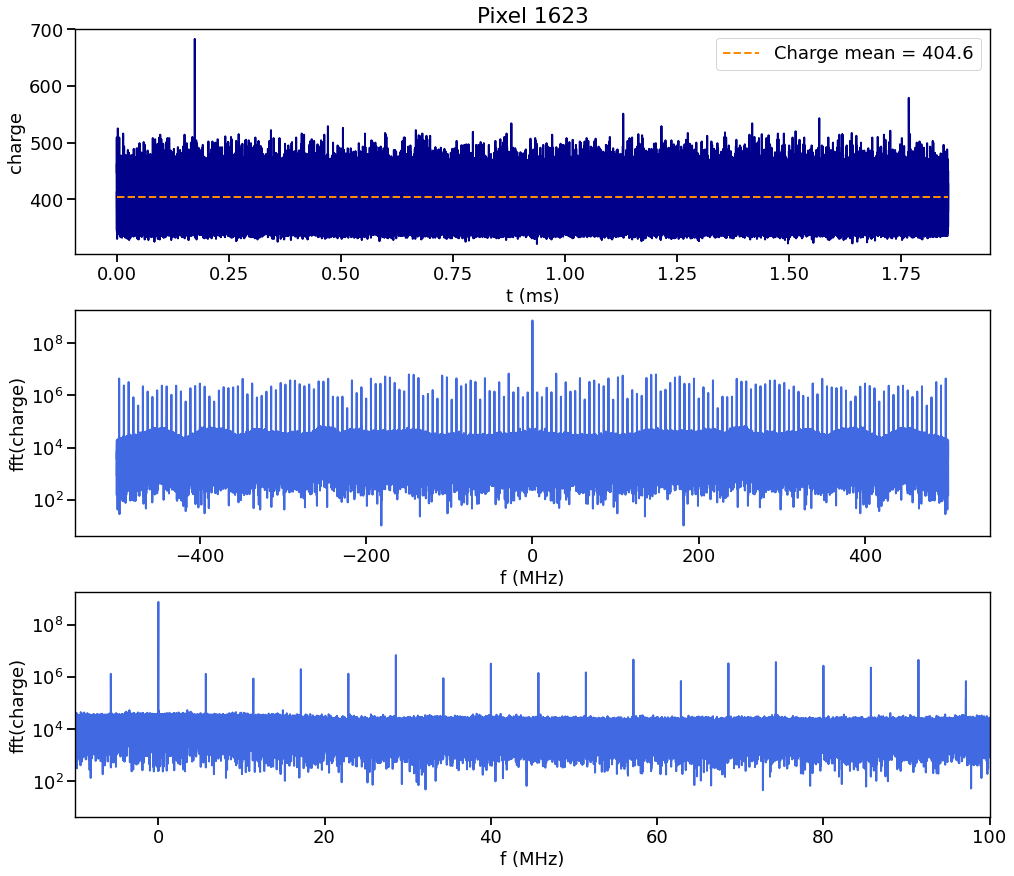

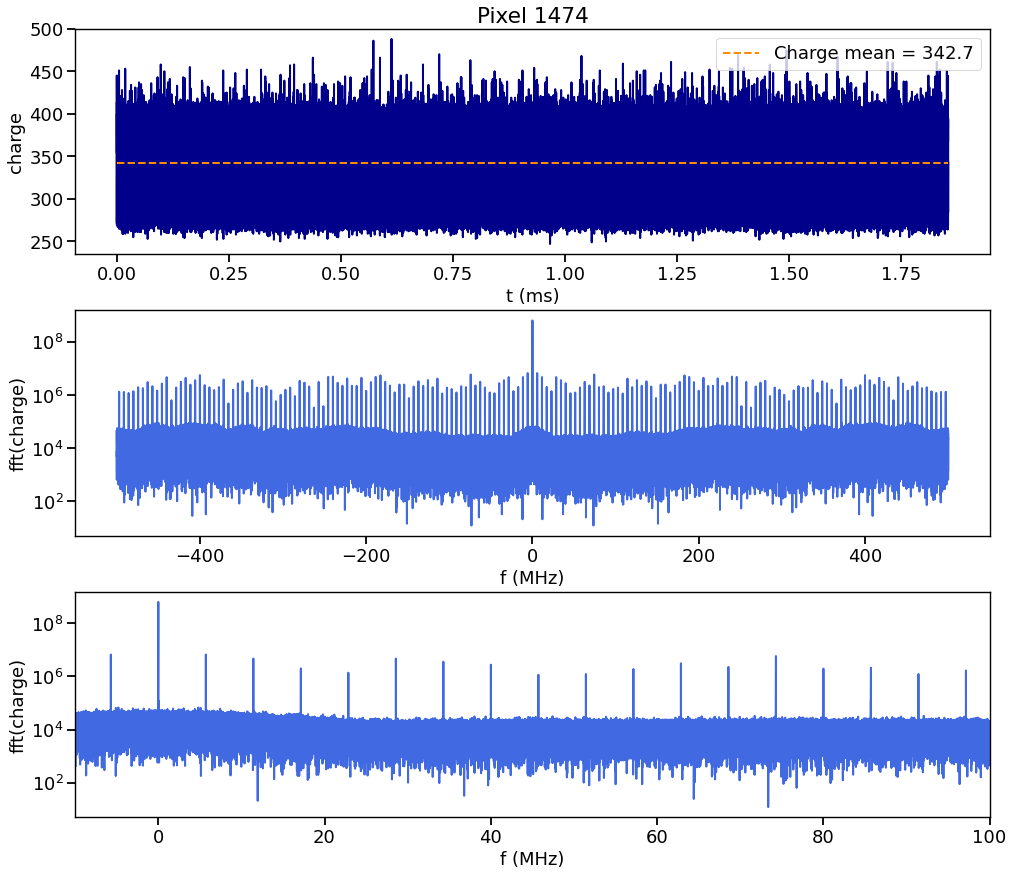

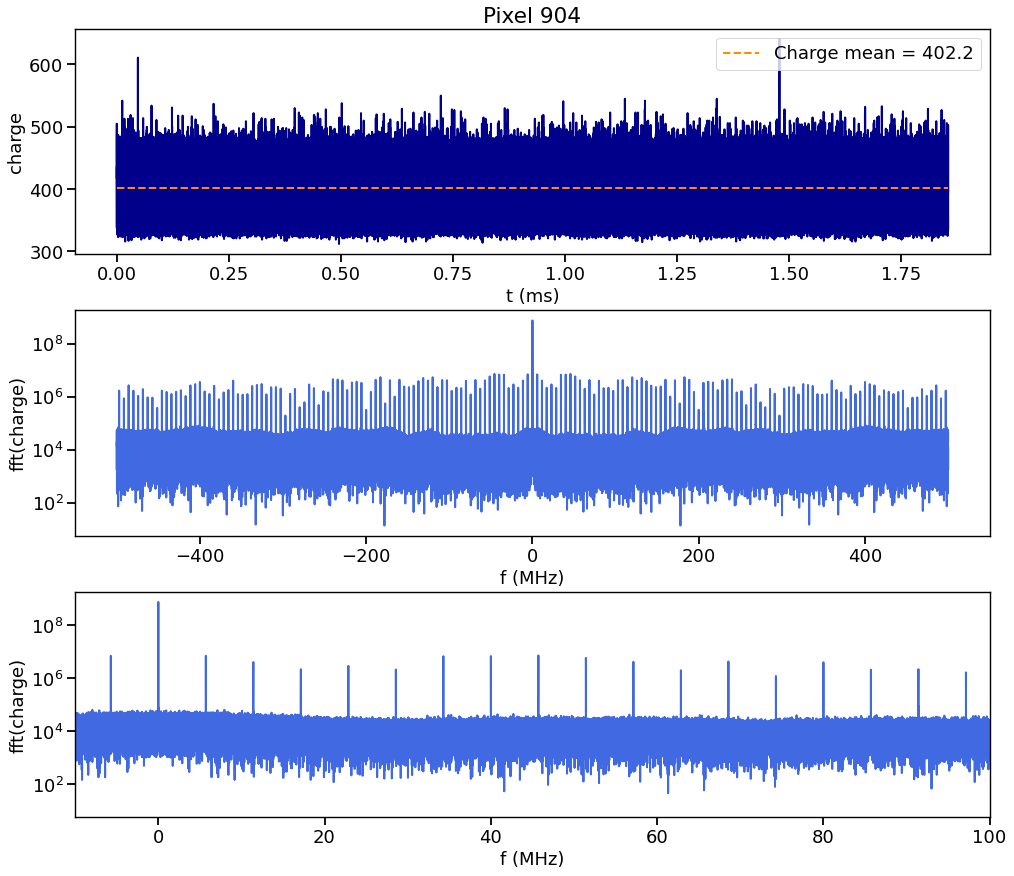

The limit in the frequency filtering is 4141675.78

Start filtering...
Filtering... 0.0%
Filtering    100%

The smallest multiple frequency is 5.71429


The high amplitudes are multiples of: 5.714 Hz 





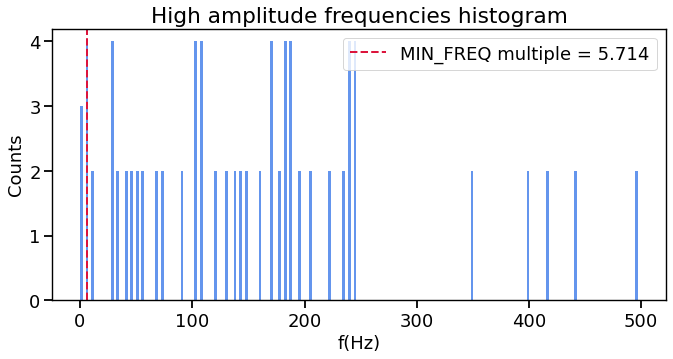


--------------------------------------------------
--------------------------------------------------




In [6]:
for RUN in RUNS: 
    
    print('\nAnalysing RUN '      + str(RUN) + ' subrun ' + str(subrun) + '\n')
    path = dir_files + 'data_Run' + str(RUN) + '_Subrun'  + str(subrun) + '_nsScale.csv'

    # reading the data from the csv
    charges, time, pixels, random_pixels = aux.readNS(path)
    
    # ----- concatenating ------ #
    # charges
    chargesTotal = []
    for px in range(len(charges)):
        tempC = [charges[px][ev][j] for ev in range(len(charges[px])) for j in range(len(charges[px][ev]))]
        chargesTotal.append(tempC)

    # times
    LenEvent     = len(charges[0][0])
    timeTotal    = np.array([(ev * LenEvent + j ) * 1e-9 for ev in range(len(charges[0]))for j in range(LenEvent)])

    timeTotal_ms = timeTotal * 1e3    # time in miliseconds   
    
    
    # ------- fourier transform and means ------- #
    
    #fourier transform elements
    dt = np.mean(np.diff(timeTotal))    # time-step
    N  = len(timeTotal)                 # number of elements 
    f  = fftshift(fftfreq(N, dt))       # frequency range
    f  = f * 1e-6                       # to mega Hertz

    #mean values calculus
    print('Calculating means...\n')
    meanCharge = [np.mean(chargesTotal[px]) for px in range(random_pixels)]

    #fourier transforms of charges
    print('Calculating fft...')
    fftCharge  = [fftshift((fft(np.array(chargesTotal[px])))) for px in range(random_pixels)]
    print('Finished')
    
    # ------------------------------------------- #
    
    # ------- individual pixels fft plots ------- #
    
    for px in range(len(pixels)):
        fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(14,12))
        fig.tight_layout()
        ax1.set_title('Pixel ' + str(pixels[px]+1))

        # ------ charge ------ #
        ax1.plot(timeTotal_ms, chargesTotal[px], '-')
        ax1.plot([0, timeTotal_ms[timeTotal_ms.size - 1] - timeTotal_ms[0]], [meanCharge[px], meanCharge[px]],
                 '--', color='darkorange', label='Charge mean = '+str(round(np.mean(chargesTotal[px]),1)))
        ax1.legend(loc=1)

        ax1.set_ylabel('charge')
        ax1.set_xlabel('t (ms)')


        # ------ FFT ------ #
        ax2.plot(f, abs(fftCharge[px]), '-', color='royalblue')

        ax2.set_yscale('log')
        ax2.set_ylabel('fft(charge)')
        ax2.set_xlabel('f (MHz)')


        # ------ ZOOM FFT ------ #
        ax3.plot(f, abs(fftCharge[px]), '-', color='royalblue')

        ax3.set_ylabel('fft(charge)')
        ax3.set_xlabel('f (MHz)')
        ax3.set_yscale('log')
        ax3.set_xlim(-10,100)

        plt.savefig(dir_graphs + 'nsScale_fft_px' + str(pixels[px]) + '_Run' + str(RUN) + '_Subrun' + 
                    str(subrun) + '.' + graphs_format, bbox_inches = 'tight', format=graphs_format)
        plt.show()
    # ------------------------------------------- #
    
    
    # filtering the frequencies
    abs_f, f_around = aux.freqFilterNS(f, fftCharge, pixels)
    
    # ----- histogram frequencies plot ----- #
    
    fig,ax1 = plt.subplots(figsize=(11,5))
    ax1.set_title('High amplitude frequencies histogram')
    ax1.set_xlabel('f(Hz)')
    ax1.set_ylabel('Counts')
    ax1.hist(abs_f, bins=200, color='cornflowerblue')

    ax1.axvline(np.mean(f_around), linestyle='--', color='crimson', 
                label='MIN_FREQ multiple = ' + str(round(np.mean(f_around),3)))

    plt.legend()
    plt.savefig(dir_graphs + 'nsScale_hist_highAmplitudes_Run' + str(RUN) + '_Subrun' + str(subrun) +
                '.' + graphs_format, bbox_inches='tight', format=graphs_format)
    plt.show()
    
    print('\n' + '-' * 50 + '\n' + '-' * 50 + '\n\n')